# 1-1. Categorize job titles using the rule-based approach

LinkedIn job posting data (2023-2024) is provided by: https://www.kaggle.com/datasets/arshkon/linkedin-job-postings

Author: Yu Kyung Koh

Last Updated: 2025/04/05

In [2]:
import pandas as pd
import numpy as np
import os
import re
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

## SECTION 1: Import raw dataset

In [4]:
datadir = '/Users/yukyungkoh/Desktop/1_Post-PhD/7_Python-projects/2_practice-NLP_job-posting_NEW/2_data/raw_data/kaggle_linked_2023-2024/'
jobposting_file = os.path.join(datadir, 'postings.csv')

posting_df = pd.read_csv(jobposting_file)

posting_df.head()

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,...,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,38480.0,8540.0,34021.0
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,...,NaN,1.712858e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,83200.0,80521.0,8069.0
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,...,We are currently accepting resumes for FOH - A...,1.713278e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,55000.0,45202.0,39061.0
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,...,This position requires a baseline understandin...,1.712896e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,157500.0,11040.0,36059.0
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",NaN,3.0,NaN,...,NaN,1.713452e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,70000.0,52601.0,19057.0


In [5]:
## Get statistics about each column of the df 
posting_df.describe(include='all')

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
count,1.238490e+05,122130,123849,123842,2.979300e+04,36073,123849,1.221320e+05,122160.000000,6280.000000,...,2439,1.238490e+05,83881,123849.0,123849,36073,36073,3.607300e+04,102977.000000,96434.000000
unique,NaN,24428,72521,107827,NaN,5,8526,NaN,NaN,NaN,...,2212,NaN,4443,NaN,7,6,1,NaN,NaN,NaN
top,NaN,Liberty Healthcare and Rehabilitation Services,Sales Manager,Position Summary: Our Sales Manager has managi...,NaN,YEARLY,United States,NaN,NaN,NaN,...,This position requires the following skills: E...,NaN,www.click2apply.net,NaN,FULL_TIME,USD,BASE_SALARY,NaN,NaN,NaN
freq,NaN,1108,673,474,NaN,20628,8125,NaN,NaN,NaN,...,28,NaN,3811,NaN,98814,36058,36073,NaN,NaN,NaN
mean,3.896402e+09,NaN,NaN,NaN,9.193942e+04,NaN,NaN,1.220401e+07,14.618247,22015.619876,...,NaN,1.713204e+12,NaN,0.0,NaN,NaN,NaN,2.053270e+05,50400.491887,28713.879887
std,8.404355e+07,NaN,NaN,NaN,7.011101e+05,NaN,NaN,2.554143e+07,85.903598,52255.873846,...,NaN,3.989122e+08,NaN,0.0,NaN,NaN,NaN,5.097627e+06,30252.232515,16015.929825
min,9.217160e+05,NaN,NaN,NaN,1.000000e+00,NaN,NaN,1.009000e+03,1.000000,0.000000,...,NaN,1.711317e+12,NaN,0.0,NaN,NaN,NaN,0.000000e+00,1001.000000,1003.000000
25%,3.894587e+09,NaN,NaN,NaN,4.828000e+01,NaN,NaN,1.435200e+04,3.000000,18.940000,...,NaN,1.712886e+12,NaN,0.0,NaN,NaN,NaN,5.200000e+04,24112.000000,13121.000000
50%,3.901998e+09,NaN,NaN,NaN,8.000000e+04,NaN,NaN,2.269650e+05,4.000000,25.500000,...,NaN,1.713408e+12,NaN,0.0,NaN,NaN,NaN,8.150000e+04,48059.000000,29183.000000
75%,3.904707e+09,NaN,NaN,NaN,1.400000e+05,NaN,NaN,8.047188e+06,8.000000,2510.500000,...,NaN,1.713484e+12,NaN,0.0,NaN,NaN,NaN,1.250000e+05,78201.000000,42077.000000


In [6]:
## Drop if "title" is missing 
posting_df['title'].isna().sum()  ## Counting how many NA values are in the 'title' column 

0

In [7]:
## => The data contains no missing entries for the 'title' column

## Count missing values in "company_name" column
int(posting_df['company_name'].isna().sum())  ## Small number of missing values compared to the total # of observations 

1719

In [8]:
#posting_df.iloc[22]

## SECTION 2: Combine columns related to job description

In [10]:
# Keep only the specified columns
posting_fewcols_df = posting_df[["job_id", "company_name", "title", "description", "skills_desc", "work_type", "normalized_salary"]].copy()
    ## Without ".copy()", the new dataa not a full copy — it's a view. You can avoid downstream issues by explicitly making a copy.

# Display the first few rows to verify
posting_fewcols_df.head()


,job_id,company_name,title,description,skills_desc,work_type,normalized_salary
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,Requirements: \n\nWe are seeking a College or ...,FULL_TIME,38480.0
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",NaN,FULL_TIME,83200.0
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,We are currently accepting resumes for FOH - A...,FULL_TIME,55000.0
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,This position requires a baseline understandin...,FULL_TIME,157500.0
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,NaN,FULL_TIME,70000.0


In [11]:
# Combine "description" and "skills_desc" into a single column
posting_fewcols_df["combined_desc"] = posting_fewcols_df["description"].fillna('') + "\n\n" + posting_fewcols_df["skills_desc"].fillna('')

# Display the first few rows to verify
posting_fewcols_df.head()

,job_id,company_name,title,description,skills_desc,work_type,normalized_salary,combined_desc
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,Requirements: \n\nWe are seeking a College or ...,FULL_TIME,38480.0,Job descriptionA leading real estate firm in N...
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",NaN,FULL_TIME,83200.0,"At Aspen Therapy and Wellness , we are committ..."
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,We are currently accepting resumes for FOH - A...,FULL_TIME,55000.0,The National Exemplar is accepting application...
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,This position requires a baseline understandin...,FULL_TIME,157500.0,Senior Associate Attorney - Elder Law / Trusts...
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,NaN,FULL_TIME,70000.0,Looking for HVAC service tech with experience ...


In [12]:
## Dropping description and skills_desc columns 
posting_fewcols_df = posting_fewcols_df.drop(['description','skills_desc'], axis=1)
posting_fewcols_df.head()

,job_id,company_name,title,work_type,normalized_salary,combined_desc
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,FULL_TIME,38480.0,Job descriptionA leading real estate firm in N...
1,1829192,NaN,Mental Health Therapist/Counselor,FULL_TIME,83200.0,"At Aspen Therapy and Wellness , we are committ..."
2,10998357,The National Exemplar,Assitant Restaurant Manager,FULL_TIME,55000.0,The National Exemplar is accepting application...
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,FULL_TIME,157500.0,Senior Associate Attorney - Elder Law / Trusts...
4,35982263,NaN,Service Technician,FULL_TIME,70000.0,Looking for HVAC service tech with experience ...


In [13]:
## Save current data
cleandatadir = '/Users/yukyungkoh/Desktop/1_Post-PhD/7_Python-projects/2_practice-NLP_job-posting/2_data/cleaned_data'
currentfile = os.path.join(cleandatadir, '0_job-posting_all.csv')
posting_fewcols_df.to_csv(currentfile, index=False)

# SECTION 3: Investigate job titles 

My eventual goal is to group job titles into broader categories. Doing so would allow me to analyze what skills are most required for each job title.

To do this, I first need to analyze the 'title' column in the data. 

In [15]:
## First, see how many unique job titles are in this data 

unique_titles = posting_fewcols_df['title'].unique()
num_unique_titles = posting_fewcols_df['title'].nunique()

print('There are ', num_unique_titles, ' unique job titles in this data.')

There are  72521  unique job titles in this data.



Because there are so many unique job titles, it is unclear how to effectively categorize the job titles.

Let's first analyze the most common keywords in the "title" column to inform my keyword rules. Based on this analysis, I will extract the top keywords to use when categorizing job titles. 

### SECTION 3.1: See top keywords from job titles as a table (Unigram)

In [18]:
# 1. Clean and tokenize job titles
def clean_and_tokenize(title):
    if not isinstance(title, str):
        return []

    # Lowercase and remove numbers/special characters (except spaces)
    title_clean = re.sub(r'[^a-zA-Z\s]', '', title.lower())
    
    # re.sub( [what to replace] ,'', object)
    #      replaces any [what to replace] to an empty string ('') inside the 'object'
    #        r'[^a-zA-Z\s]'
    #          ^ : anything that is NOT
    #          a-zA-Z : uppercase and lowercase letters
    #          \s : whitespace character
    
    # Tokenize (split into words)
    words = title_clean.split()

    # Remove common stopwords
    stopwords = {"and", "of", "the", "in", "to", "for", "with", "a", "on", "at", "as"}
    words = [word for word in words if word not in stopwords]

    return words

# 2. Apply to all job titles
all_words = posting_fewcols_df["title"].dropna().apply(clean_and_tokenize)
all_words

0                                  [marketing, coordinator]
1                      [mental, health, therapistcounselor]
2                           [assitant, restaurant, manager]
3         [senior, elder, law, trusts, estates, associat...
4                                     [service, technician]
                                ...                        
123844                  [title, ixinvestigations, attorney]
123845    [staff, software, engineer, ml, serving, platf...
123846               [account, executive, oregonwashington]
123847                     [business, development, manager]
123848               [marketing, social, media, specialist]
Name: title, Length: 123849, dtype: object

In [19]:
flat_words = [word for sublist in all_words for word in sublist] ## Flattening to get a list of all words in job titles 
flat_words[:5]

['marketing', 'coordinator', 'mental', 'health', 'therapistcounselor']

In [20]:
# 3. Count word frequencies
word_counts = Counter(flat_words)

In [21]:
# 4. Convert to DataFrame
top_words_df = pd.DataFrame(word_counts.most_common(50), columns=["keyword", "count"])

In [22]:
# Show the top 30 words 
top_words_df.head(10)

,keyword,count
0,manager,18069
1,engineer,9870
2,sales,8200
3,senior,8014
4,assistant,6795
5,associate,6672
6,specialist,6611
7,technician,5265
8,nurse,5074
9,analyst,4798


<Figure size 1200x1000 with 0 Axes>

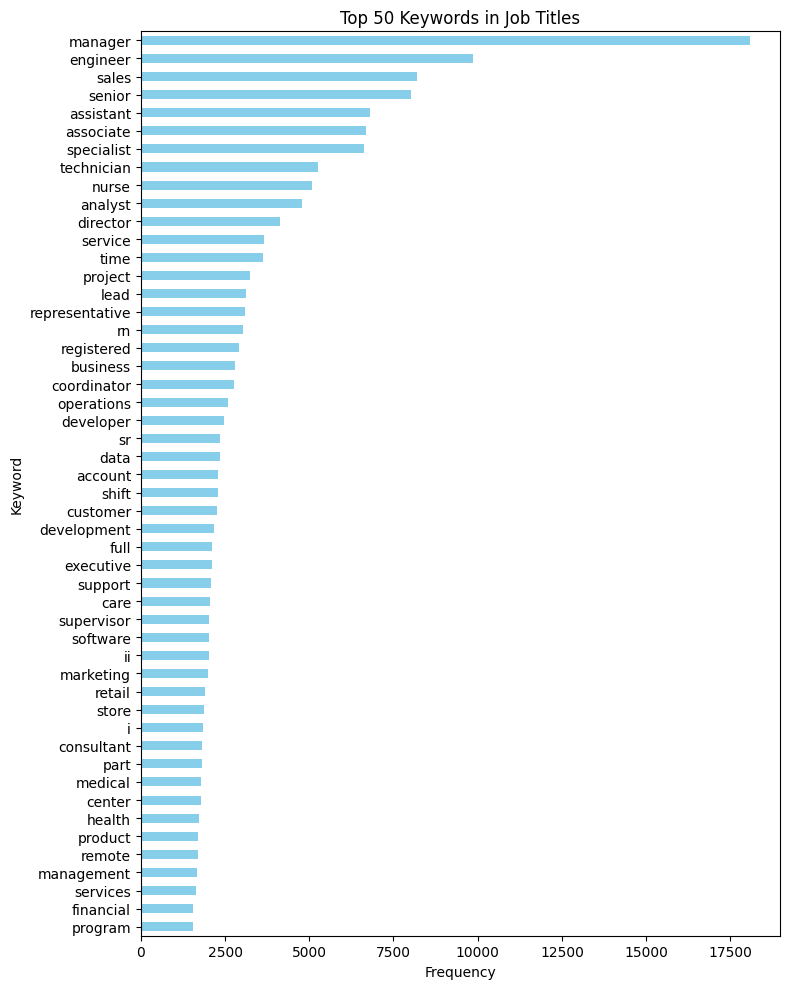

In [23]:
# Bar Plot
# Plot top 50 keywords
plt.figure(figsize=(12, 10))  # Adjust size for better readability
top_words_df.plot(kind='barh', x='keyword', y='count', legend=False, color='skyblue', figsize=(8, 10))
plt.title("Top 50 Keywords in Job Titles")
plt.xlabel("Frequency")
plt.ylabel("Keyword")
plt.gca().invert_yaxis()  # Most frequent at top
plt.tight_layout()
plt.show()

I now want to examine how job titles containing certain keywords typically appear. This will help me develop a rule to classify each job title into a broader category.

In [25]:
## I want to see ALL titles that contain the term "associate"
associate_title_list = posting_fewcols_df[posting_fewcols_df["title"]
                                           .str.contains("associate", case=False, na=False)]["title"].tolist()
associate_title_list[:30]

['Senior Elder Law / Trusts and Estates Associate Attorney',
 'Inside Customer Service Associate',
 'Associate Attorney',
 'Sales Associate Natural Food Products',
 'Associate Planner',
 'Client Service Associate',
 'Fundraising Associate',
 'Client Service Associate / Practice Manager',
 'Tax Associate',
 'Commercial Litigation Associate Attorney',
 'Associate Brand Manager',
 'Associate Attorney',
 'Senior Retail Sales Associate',
 'Associate Attorney',
 'Associate Attorney - Commercial Litigation',
 'Associate Attorney',
 'Wellness Associate',
 'Associate Director of Individual Giving',
 'Program Associate',
 'Investor Relations Associate',
 'Sales Associate',
 'FL Bar Associate Attorney Tax, Trusts, and Estates',
 'Associate Veterinarian',
 'Real Estate Broker Associate',
 'Associate Attorney',
 'Resource Development Associate Director',
 'Associate Marketing Manager',
 'Registered Client Service Associate',
 'Warehouse Associate',
 'Associate - Job #1868']

In [26]:
## I want to see ALL titles that contain the term "specialist"
specialist_title_list = posting_fewcols_df[posting_fewcols_df["title"]
                                           .str.contains("specialist", case=False, na=False)]["title"].tolist()
specialist_title_list[:30]

['Software Support Specialist',
 'Marketing Specialist',
 'Social Security Specialist / Retirement Benefit Advisor (Remote)',
 'Front end specialist',
 'Operations Specialist',
 'Accounting Specialist',
 'Client Relationship Specialist',
 'Social Media Marketing Specialist Internship',
 'Leasing & Property Management Specialist (Part-Time with Growth Potential)',
 'Field Operations Specialist',
 'Inbound Call Center Specialist',
 'Accounts Payable Specialist',
 'Quality Assurance Specialist',
 'Managed File Transfer Specialist (connect direct , NDM) | REMOTE ROLE',
 'Inbound Sales & Onboarding Specialist',
 'Litigation Support Specialist',
 'Distributor Sales Specialist',
 'Accounts Payable Specialist',
 'Records Specialist & Academic Scheduler',
 'Product Support Specialist',
 'Customer Service Specialist',
 'Logistics Specialist',
 'Senior Staffing Specialist',
 'Sales And Marketing Specialist',
 'Search Engine Optimization Specialist',
 'Service Specialist',
 'Financial Planning Spe

In [27]:
## I want to see ALL titles that contain the term "analyst"
analyst_title_list = posting_fewcols_df[posting_fewcols_df["title"]
                                           .str.contains("analyst", case=False, na=False)]["title"].tolist()
analyst_title_list[:30]

['Board Certified Behavior Analyst',
 'FP&A Analyst',
 'Accounts Analyst',
 'Help Desk Analyst',
 'Resolution Analyst',
 'Technical Business Analyst',
 'Data Analyst',
 'Senior Data Engineer/Analyst - Full Time',
 'Oracle P2P Analyst',
 'PeopleSoft FSCM Functional Analyst - GL and KK modules',
 'Junior Business Analyst',
 'Quality process analyst | Hybrid in West Berlin, NJ',
 'Technical Business Analyst Local to Des Moines, Iowa',
 'eCommerce Data Analyst',
 'EV/Cash Flow Analyst',
 'Accounts Receivable Analyst',
 'Digital Analyst (Google Analytics)',
 'Mutual Fund Financial Reporting Analyst',
 'Senior Business Analyst (Pharma/Biotech/Scientific)',
 'Data Management Analyst',
 'Sr. Project Analyst - Value Management (Hospital & Healthcare)',
 'Senior Business Analyst',
 'Senior Analyst, Data & Analytics',
 'Private Equity Analyst',
 'Banking Operations Systems Analyst',
 'Sr. Business Analyst/Tester',
 'Fair Lending Compliance Analyst',
 'Wealth Management Business Data Analyst',
 ' 

## SECTION 3.2: See top keywords from job titles as a table (Bigram)

The previous exercise shows that the most common keywords from job titles include "manager" and "engineer", etc. 
However, these keywords are not fully informative on which job they are referring to. For example, "engineer" could be "software engineer" or "chemical engineer", which are completely. different jobs. 
Therefore, looking at bigrams (i.e., pairs of words like "data scientist", "software engineer") can be more meaningful than unigrams when analyzing job titles. 

In [29]:
# Step 1: Clean job titles
def clean_title(title):
    if not isinstance(title, str):
        return ""
    title = title.lower()
    title = re.sub(r'[^a-z\s]', '', title)  # remove punctuation/numbers
    return title

cleaned_titles = posting_fewcols_df["title"].dropna().apply(clean_title)


In [30]:
# Step 2: Add custom stopwords
custom_stopwords = {'i', 'ii', 'iii', 'iv', 'sr', 'senior', 'jr', 'mid', 'entry', 'rn'}  # you can add more


In [31]:
# Step 3: Use CountVectorizer with stopwords
vectorizer = CountVectorizer(
    ngram_range=(2, 2),  # bigrams only
    stop_words='english'  # start with default English stopwords
)

In [32]:
# Step 4: Manually filter out bigrams with unwanted words
X = vectorizer.fit_transform(cleaned_titles)
bigram_counts = X.sum(axis=0)
bigram_freq = [(bigram, bigram_counts[0, idx]) for bigram, idx in vectorizer.vocabulary_.items()]


In [33]:
# Remove bigrams containing custom stopwords
filtered_bigrams = [
    (bigram, count)
    for bigram, count in bigram_freq
    if not any(word in custom_stopwords for word in bigram.split())
]


In [34]:
# Step 5: Convert to DataFrame
top_bigrams_df = pd.DataFrame(sorted(filtered_bigrams, key=lambda x: x[1], reverse=True),
                              columns=["bigram", "count"])


In [35]:
top_bigrams_df.shape

(96721, 2)

In [36]:
top_bigrams_df.head(30)

,bigram,count
0,registered nurse,2557
1,project manager,1956
2,sales associate,1674
3,customer service,1395
4,software engineer,1318
5,sales manager,1304
6,sales representative,1066
7,store manager,1061
8,account manager,1022
9,service representative,887


# SECTION 4: Rule-based approach in categorizing job title

There could be two different ways of categorizing job titles

(i) Rule-based approach

- Requires a pre-defined job categories and a dictionary that maps keywords that appear in the job title to each job category.
- This is a simple and fast approach 

(ii) Data-driven, machine learning approach 
- More automatic approach that does not rely on pre-defined categories or dictionaries 
- Could use Occupation Classification APIs (like Lightcast or O*NET).
- Could use embeddings from sentence-transformers + clustering.
- Could use Large Language Models (LLMs) for semantic classification.

If I am interested in specific jobs (e.g. data scientist, consultant, engineers), it may be better to use the rule-based approach. Hence, I am trying this approach in this section.

I will practice the machine-learning approach at the end of this code. 

In [38]:
## Step 1: Define a dictionary where keywords map to broad job categories 
##   Note that using regular expressions with boundary (\b) is important, 
##   because otherwise, for example for "Data-related" jobs, 
##   the categorization will capture any titles that contain letters "ai" (not independent word "ai") in the job title.

def categorize_job_title(title):
    if not isinstance(title, str):
        return "Other"

    title = title.lower()

    # Use word boundaries to match whole words (e.g., \bml\b won't match "xml")
    if re.search(r"\bdata\b", title) and re.search(r"\b(scientist|engineer|analyst|architect|specialist)\b", title):
        return "Data-related"
    
    elif re.search(r"\b(machine learning|ml|ai|artificial intelligence)\b", title):
        return "Data-related"

    elif (
        re.search(r"\b(software|frontend|web|ios|android|mobile application|backend|ui)\b", title) and
        re.search(r"\b(engineer|developer)\b", title)
    ):
        return "Software/Developer"

    elif re.search(r"\bconsultant\b", title):
        return "Consultant"

    elif re.search(r"\b(marketing|brand|content|social media)\b", title):
        return "Marketing"

    elif re.search(r"\bmanager\b", title) and re.search(r"\b(product|project|program)\b", title):
        return "Product/Project Manager"

    elif re.search(r"\b(business|finance|financial)\b", title):
        return "Business/Finance Job"

    elif "manager" in title and not re.search(r"\b(product manager|project manager|program manager)\b", title):
        return "Other Manager"

    else:
        return "Other"

In [39]:
## Step 2: Apply this to the data
posting_fewcols_df["job_category"] = posting_fewcols_df["title"].apply(categorize_job_title)

In [40]:
## Step 3: Preview categories
print(posting_fewcols_df["job_category"].value_counts())

job_category
Other                      94125
Other Manager              13385
Business/Finance Job        4557
Product/Project Manager     3400
Marketing                   2598
Software/Developer          1994
Data-related                1946
Consultant                  1844
Name: count, dtype: int64




As shown above, the majority of job titles are classified as "Other".

This could be because (i) these jobs truly fall into categories I am not considering, or (ii) my classification rules fail to accurately capture certain job titles.

To better understand the potential issues with "Other" job category, I investigate which keywords most frequently appear in these job titles. 

In [42]:
## Step 4: Investigate which bigrams most frequently appears in job titles classied as "Other" 
# --- 1. Filter titles in the "Other" category
other_titles = posting_fewcols_df[posting_fewcols_df["job_category"] == "Other"]["title"].dropna()

# --- 2. Clean titles (lowercase, remove punctuation/numbers)
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # keep only letters and spaces
    return text

cleaned_other_titles = other_titles.apply(clean_text)

# --- 3. Generate bigrams using CountVectorizer
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X = vectorizer.fit_transform(cleaned_other_titles)

# --- 4. Count bigram frequencies
bigram_counts = X.sum(axis=0)
bigram_freq = [(bigram, bigram_counts[0, idx]) for bigram, idx in vectorizer.vocabulary_.items()]
bigram_freq_sorted = sorted(bigram_freq, key=lambda x: x[1], reverse=True)

# --- 5. Convert to DataFrame
top_bigrams_df = pd.DataFrame(bigram_freq_sorted[:30], columns=["bigram", "count"])

# Show the top bigrams
from IPython.display import display
display(top_bigrams_df)

,bigram,count
0,registered nurse,2498
1,sales associate,1649
2,nurse rn,1373
3,customer service,1313
4,sales representative,1030
5,service representative,883
6,account executive,777
7,retail sales,776
8,licensed practical,671
9,practical nurse,669


As shown above, many jobs in "Other" job category  fall into the jobs that I am not considering for my analysis (e.g. nurse, sales, customer service, human resources, etc.) 

However, one bigram that might capture the jobs I am trying to analyze is "project engineer." 

Let me examine how "project engineer" usually appears in the job title. 

In [44]:
## I want to see ALL titles that contain the term "project engineer"
project_engineer_title_list = posting_fewcols_df[
    (posting_fewcols_df["job_category"] == "Other") &
    (posting_fewcols_df["title"].str.contains("project engineer", case=False, na=False))]["title"].tolist()
project_engineer_title_list[:30]

['Project Engineer',
 'Senior Project Engineer',
 'Project Engineer',
 'Sr. Project Engineer',
 'Project Engineer',
 'Project Engineer',
 'Project Engineer',
 'Senior Project Engineer - Module Design and Fabrication',
 'Renewables Structural Project Engineer',
 'Construction Project Engineer',
 'Mechanical Project Engineer',
 'Project Engineer',
 'Corporate Project Engineer',
 'Corporate Project Engineer',
 'Project Engineer',
 'Project Engineer - Electrical & Controls',
 'Project Engineer',
 'Network Project Engineer',
 'Project Engineer Co-Op - Dayton, OH',
 'Project Engineer 5',
 'Electrical Instrumentation Project Engineer',
 'Project Engineer ',
 'Project Engineer / Assistant Superintendent - Utilities',
 'Construction Project Engineer - Civil',
 'Corporate Project Engineer',
 'Construction Project Engineer',
 'Project Engineer 1',
 'Project Engineer',
 'Project Engineer (Subject Matter Expert)',
 'Project Engineer']

In [45]:
## Drop if job_category is "Other" 
posting_fewcols_df = posting_fewcols_df[posting_fewcols_df["job_category"] != "Other"]

In [46]:
posting_fewcols_df.head()

,job_id,company_name,title,work_type,normalized_salary,combined_desc,job_category
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,FULL_TIME,38480.0,Job descriptionA leading real estate firm in N...,Marketing
2,10998357,The National Exemplar,Assitant Restaurant Manager,FULL_TIME,55000.0,The National Exemplar is accepting application...,Other Manager
12,56482768,NaN,Appalachian Highlands Women's Business Center,FULL_TIME,NaN,FULL JOB DESCRIPTION – PROGRAM DIRECTOR Appala...,Business/Finance Job
14,69333422,Staffing Theory,Senior Product Marketing Manager,FULL_TIME,NaN,A leading pharmaceutical company committed to ...,Marketing
18,111513530,United Methodists of Greater New Jersey,"Content Writer, Communications",FULL_TIME,NaN,"Application opening date: April 24, 2024\nTitl...",Marketing


In [47]:
## Save the data 
cleandatadir = '/Users/yukyungkoh/Desktop/1_Post-PhD/7_Python-projects/2_practice-NLP_job-posting/2_data/cleaned_data'
savefile = os.path.join(cleandatadir, '1_job-posting_jobs-categorized_df.pkl')
posting_fewcols_df.to_pickle(savefile, compression='zip')

## SECTION 5: Examine job titles for "Data-related"

(This part is added on May 18th, 2025) 

Code 3-2 shows that "Data-related" jobs include job titles that do not contain data-related keywords. I am going to investigate why here. 

In [49]:
## I want to see ALL titles in the category "Data-related" 
datajob_title_list = posting_fewcols_df[
    (posting_fewcols_df["job_category"] == "Data-related")]["title"].tolist()
#datajob_title_list